In [9]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [10]:
# Function to calculate the payoff of a European call option
def european_call_payoff(S, K):
    return np.maximum(S - K, 0.0)

# Monte Carlo simulation for European call option pricing
def monte_carlo_option_pricing(S0, K, T, r, sigma, num_simulations):
    np.random.seed(0)  # Set seed for reproducibility
    dt = T
    discount_factor = np.exp(-r * T)

    # end-of-period stock prices
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn(num_simulations))
    
    # payoff for each simulation
    payoffs = european_call_payoff(S_T, K)
    
    
    option_price = discount_factor * np.mean(payoffs)
    return option_price

In [11]:
# Function to calculate the Greeks 
def calculate_greeks(S0, K, T, r, sigma, num_simulations):
    epsilon = 0.01
    delta = (monte_carlo_option_pricing(S0 + epsilon, K, T, r, sigma, num_simulations) - 
             monte_carlo_option_pricing(S0 - epsilon, K, T, r, sigma, num_simulations)) / (2 * epsilon)
    gamma = (monte_carlo_option_pricing(S0 + epsilon, K, T, r, sigma, num_simulations) - 
             2 * monte_carlo_option_pricing(S0, K, T, r, sigma, num_simulations) + 
             monte_carlo_option_pricing(S0 - epsilon, K, T, r, sigma, num_simulations)) / (epsilon ** 2)
    vega = (monte_carlo_option_pricing(S0, K, T, r, sigma + epsilon, num_simulations) - 
            monte_carlo_option_pricing(S0, K, T, r, sigma - epsilon, num_simulations)) / (2 * epsilon)
    theta = (monte_carlo_option_pricing(S0, K, T - epsilon, r, sigma, num_simulations) - 
             monte_carlo_option_pricing(S0, K, T + epsilon, r, sigma, num_simulations)) / (2 * epsilon)
    rho = (monte_carlo_option_pricing(S0, K, T, r + epsilon, sigma, num_simulations) - 
           monte_carlo_option_pricing(S0, K, T, r - epsilon, sigma, num_simulations)) / (2 * epsilon)
    return delta, gamma, vega, theta, rho

# Function to plot the volatility surface
def plot_volatility_surface(ticker):
    option_chain = yf.Ticker(ticker).option_chain()
    calls = option_chain.calls
    strikes = calls['strike']
    expirations = [1/12, 2/12, 3/12, 4/12, 5/12, 6/12, 9/12, 1, 2]  
    volatilities = []

    for T in expirations:
        vol_row = []
        for K in strikes:
            option_price = monte_carlo_option_pricing(S0, K, T, r, sigma, num_simulations)
            implied_vol = np.sqrt(2 * np.pi / T) * (option_price / S0) 
            vol_row.append(implied_vol)
        volatilities.append(vol_row)

    X, Y = np.meshgrid(strikes, expirations)
    Z = np.array(volatilities)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('Implied Volatility')
    plt.show()

In [12]:
# parameters
S0 = 100  
K = 105  
T = 1.0  
r = 0.05  
sigma = 0.2  
num_simulations = 10000  

In [13]:
# option price
option_price = monte_carlo_option_pricing(S0, K, T, r, sigma, num_simulations)
print(f"The estimated price of the European call option is: {option_price:.2f}")

The estimated price of the European call option is: 7.70


In [14]:
# Greeks
delta, gamma, vega, theta, rho = calculate_greeks(S0, K, T, r, sigma, num_simulations)
print(f"Delta: {delta:.2f}, Gamma: {gamma:.2f}, Vega: {vega:.2f}, Theta: {theta:.2f}, Rho: {rho:.2f}")

Delta: 0.53, Gamma: 0.03, Vega: 37.91, Theta: -6.06, Rho: 45.16


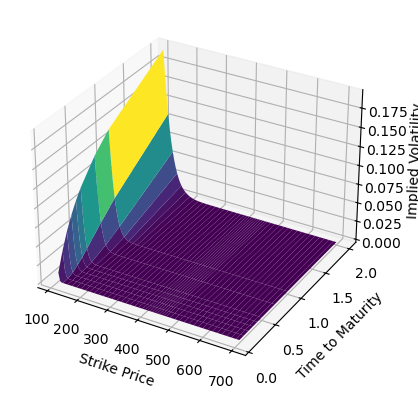

In [16]:
# volatility surface
plot_volatility_surface('MSFT')

In [ ]:
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime

# Black-Scholes formula
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Function to calculate implied volatility
def implied_volatility(option_price, S, K, T, r, option_type="call"):
    def objective_function(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - option_price

    try:
        iv = brentq(objective_function, 1e-6, 5)  # Solve for implied volatility
        return iv
    except ValueError:
        return np.nan  # Return NaN if no solution is found

In [125]:
# Helper function to plot volatility smiles
def plot_volatility_smile(strikes, implied_vols, label, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(strikes, implied_vols, label=label)
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# choose the expiration with the most data points
def choose_best_expiration(ticker):
    max_data_points = 0
    best_expiration = None
    for expiration in ticker.options:
        try:
            option_chain = ticker.option_chain(expiration)
            calls = option_chain.calls

            num_data_points = len(calls)
            if num_data_points > max_data_points:
                max_data_points = num_data_points
                best_expiration = expiration
        except Exception as e:
            print(f"Error fetching data for expiration {expiration}: {e}")
    print(f"Chosen expiration for {ticker.ticker}: {best_expiration} with {max_data_points} data points")
    return best_expiration


In [ ]:
# risk-free rate 
risk_free_rate = 0.05  # Example - to possibly be replaced with a better proxy

# Current date for maturity calculation
current_date = datetime.now()

In [ ]:
# equity index options data (S&P 500)
equity_ticker1 = "^SPX"  
spx = yf.Ticker(equity_ticker1)
spx_expiration = choose_best_expiration(spx)
spx_chain = spx.option_chain(spx_expiration)
spx_calls = spx_chain.calls

# Underlying price
spx_price = spx.history(period="1d")['Close'].iloc[-1]

# Time to maturity
spx_maturity = (datetime.strptime(spx_expiration, "%Y-%m-%d") - current_date).days / 365.0

# implied volatilities
spx_strikes = spx_calls['strike']
spx_market_prices = spx_calls['lastPrice']
spx_vols = [
    implied_volatility(price, spx_price, strike, spx_maturity, risk_free_rate)
    for price, strike in zip(spx_market_prices, spx_strikes)
]

Chosen expiration for ^SPX: 2025-01-17 with 419 data points


In [ ]:
# equity index options data (Nasdaq-100)
equity_ticker2 = "^NDX"  # Nasdaq-100 index
ndx = yf.Ticker(equity_ticker2)
ndx_expiration = choose_best_expiration(ndx)
ndx_chain = ndx.option_chain(ndx_expiration)
ndx_calls = ndx_chain.calls

# Underlying price
ndx_price = ndx.history(period="1d")['Close'].iloc[-1]

# Time to maturity
ndx_maturity = (datetime.strptime(ndx_expiration, "%Y-%m-%d") - current_date).days / 365.0

# Calculate implied volatilities
ndx_strikes = ndx_calls['strike']
ndx_market_prices = ndx_calls['lastPrice']
ndx_vols = [
    implied_volatility(price, ndx_price, strike, ndx_maturity, risk_free_rate)
    for price, strike in zip(ndx_market_prices, ndx_strikes)
]

Chosen expiration for ^NDX: 2025-01-17 with 465 data points


In [ ]:
# Russell 2000 options data 
equity_ticker3 = "^RUT"  
rut = yf.Ticker(equity_ticker3)
rut_expiration = choose_best_expiration(rut)
rut_chain = rut.option_chain(rut_expiration)
rut_calls = rut_chain.calls

# Underlying price
rut_price = rut.history(period="1d")['Close'].iloc[-1]

# Time to maturity
rut_maturity = (datetime.strptime(rut_expiration, "%Y-%m-%d") - current_date).days / 365.0

# Calculate implied volatilities
rut_strikes = rut_calls['strike']
rut_market_prices = rut_calls['lastPrice']
rut_vols = [
    implied_volatility(price, rut_price, strike, rut_maturity, risk_free_rate)
    for price, strike in zip(rut_market_prices, rut_strikes)
]

Chosen expiration for ^RUT: 2025-02-21 with 174 data points


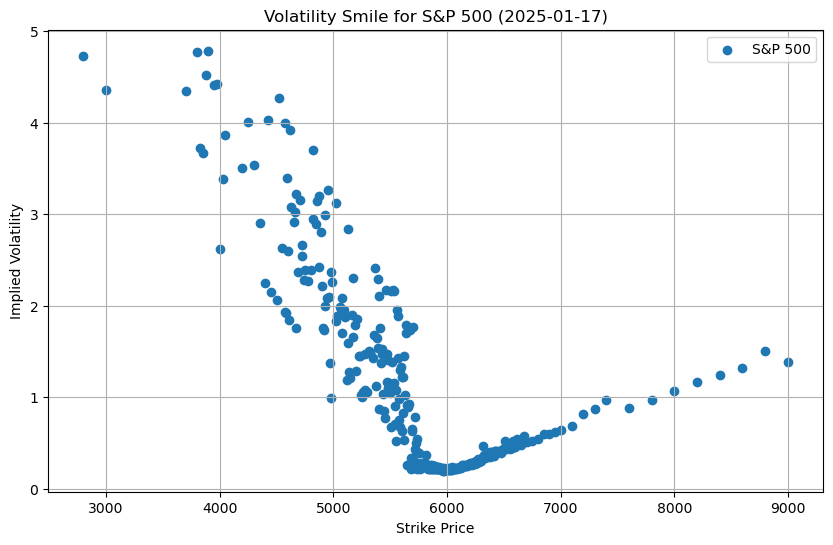

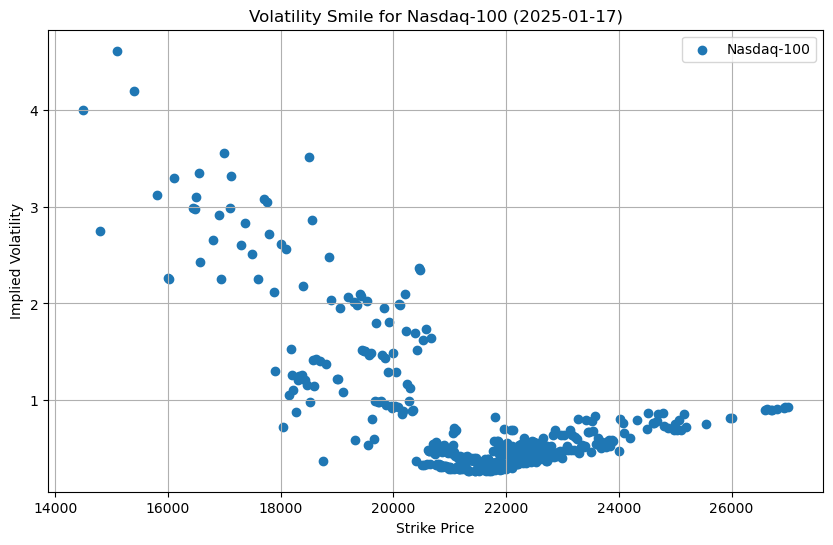

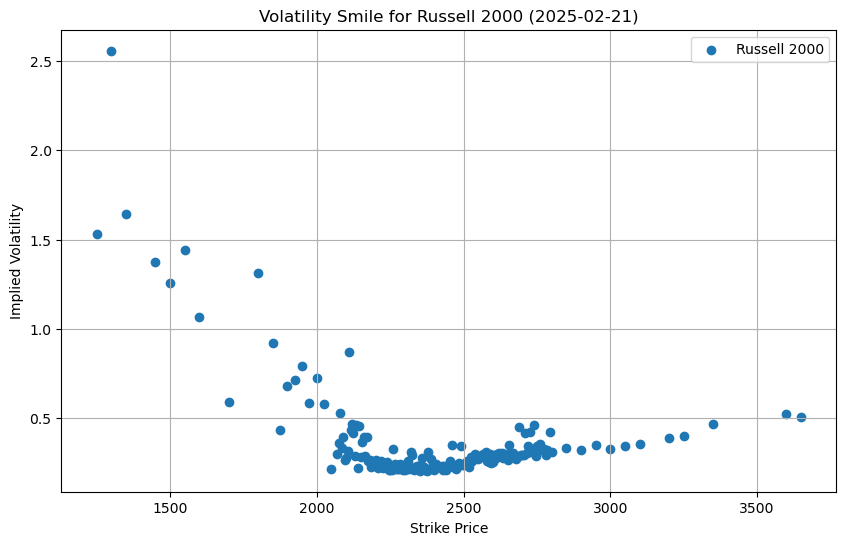

In [133]:
# Plotting
plot_volatility_smile(spx_strikes, spx_vols, label="S&P 500", title=f"Volatility Smile for S&P 500 ({spx_expiration})")
plot_volatility_smile(ndx_strikes, ndx_vols, label="Nasdaq-100", title=f"Volatility Smile for Nasdaq-100 ({ndx_expiration})")
plot_volatility_smile(rut_strikes, rut_vols, label="Russell 2000", title=f"Volatility Smile for Russell 2000 ({rut_expiration})")